# Configuració entorn GPU

In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Càrrega Dades

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'dataBalanced' 

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
BATCH_SIZE = 16
IMG_SIZE = (256, 256)

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1168 files belonging to 2 classes.


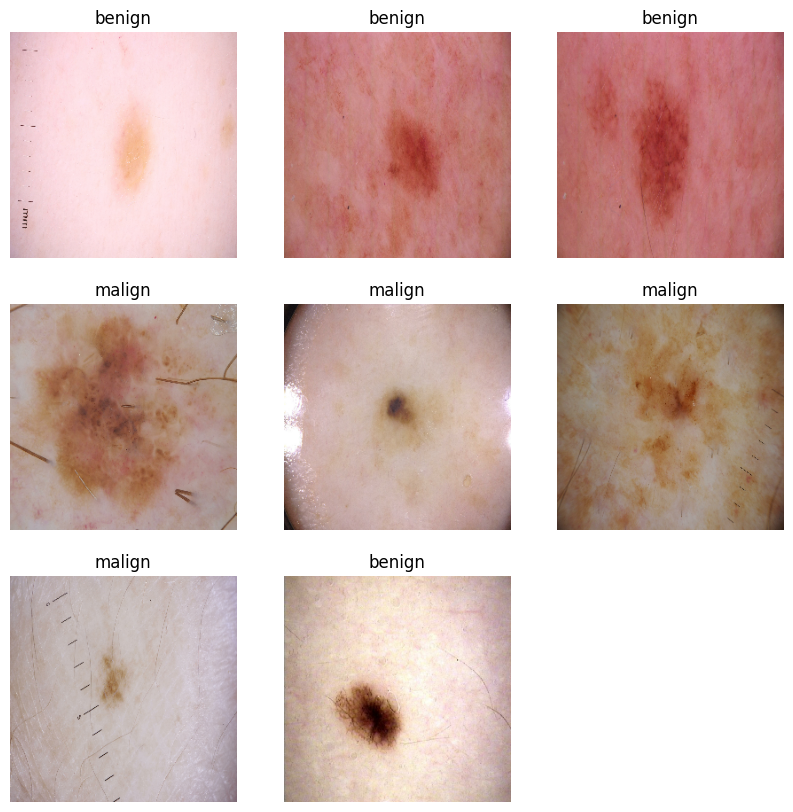

In [8]:
class_names = data.class_names

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val.prefetch(buffer_size=AUTOTUNE)
test_dataset = test.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [13]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.Rescaling(scale=1./255)

# Elaboració model

In [15]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 8, 8, 1280)


In [17]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

 block2c_expand_activation (Act  (None, 64, 64, 192)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 64, 64, 48)   9216        ['block2c_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 64, 64, 48)  192         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_drop (Dropout)         (None, 64, 64, 48)   0           ['block2c_project_bn[0][0]']     
          

                                                                  'block3b_add[0][0]']            
                                                                                                  
 block3d_expand_conv (Conv2D)   (None, 32, 32, 256)  147456      ['block3c_add[0][0]']            
                                                                                                  
 block3d_expand_bn (BatchNormal  (None, 32, 32, 256)  1024       ['block3d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3d_expand_activation (Act  (None, 32, 32, 256)  0          ['block3d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3d_p

                                                                                                  
 block4b_project_conv (Conv2D)  (None, 16, 16, 128)  65536       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 16, 16, 128)  512        ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (Dropout)         (None, 16, 16, 128)  0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 16, 16, 128)  0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
          

                                                                                                  
 block4d_drop (Dropout)         (None, 16, 16, 128)  0           ['block4d_project_bn[0][0]']     
                                                                                                  
 block4d_add (Add)              (None, 16, 16, 128)  0           ['block4d_drop[0][0]',           
                                                                  'block4c_add[0][0]']            
                                                                                                  
 block4e_expand_conv (Conv2D)   (None, 16, 16, 512)  65536       ['block4d_add[0][0]']            
                                                                                                  
 block4e_expand_bn (BatchNormal  (None, 16, 16, 512)  2048       ['block4e_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 16, 16, 768)  98304       ['block4f_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 16, 16, 768)  3072       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 16, 16, 768)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv2 (DepthwiseConv  (None, 16, 16, 768)  6912       ['block5a_expand_activation[0][0]
 2D)      

 2D)                                                             ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 16, 16, 960)  3840       ['block5c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 16, 16, 960)  0          ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 960)         0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5e_activation (Activation  (None, 16, 16, 960)  0          ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 960)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5e_se_reshape[0][0]']     
                                                                                                  
 block5e_s

                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5g_se_reshape[0][0]']     
                                                                                                  
 block5g_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5g_se_reduce[0][0]']      
                                                                                                  
 block5g_se_excite (Multiply)   (None, 16, 16, 960)  0           ['block5g_activation[0][0]',     
                                                                  'block5g_se_expand[0][0]']      
                                                                                                  
 block5g_p

 block5i_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5i_se_reduce[0][0]']      
                                                                                                  
 block5i_se_excite (Multiply)   (None, 16, 16, 960)  0           ['block5i_activation[0][0]',     
                                                                  'block5i_se_expand[0][0]']      
                                                                                                  
 block5i_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block5i_se_excite[0][0]']      
                                                                                                  
 block5i_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block5i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5i_d

 block6b_drop (Dropout)         (None, 8, 8, 256)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 8, 8, 256)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 8, 8, 1536)   393216      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 8, 8, 1536)  6144        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6c_e

 block6e_expand_conv (Conv2D)   (None, 8, 8, 1536)   393216      ['block6d_add[0][0]']            
                                                                                                  
 block6e_expand_bn (BatchNormal  (None, 8, 8, 1536)  6144        ['block6e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6e_expand_activation (Act  (None, 8, 8, 1536)  0           ['block6e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6e_dwconv2 (DepthwiseConv  (None, 8, 8, 1536)  13824       ['block6e_expand_activation[0][0]
 2D)                                                             ']                               
          

 block6g_expand_activation (Act  (None, 8, 8, 1536)  0           ['block6g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6g_dwconv2 (DepthwiseConv  (None, 8, 8, 1536)  13824       ['block6g_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6g_bn (BatchNormalization  (None, 8, 8, 1536)  6144        ['block6g_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6g_activation (Activation  (None, 8, 8, 1536)  0           ['block6g_bn[0][0]']             
 )        

                                                                                                  
 block6i_bn (BatchNormalization  (None, 8, 8, 1536)  6144        ['block6i_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6i_activation (Activation  (None, 8, 8, 1536)  0           ['block6i_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6i_se_squeeze (GlobalAver  (None, 1536)        0           ['block6i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6i_s

 )                                                                                                
                                                                                                  
 block6k_se_squeeze (GlobalAver  (None, 1536)        0           ['block6k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6k_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6k_se_squeeze[0][0]']     
                                                                                                  
 block6k_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6k_se_reshape[0][0]']     
                                                                                                  
 block6k_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6k_se_reduce[0][0]']      
          

 block6m_se_reshape (Reshape)   (None, 1, 1, 1536)   0           ['block6m_se_squeeze[0][0]']     
                                                                                                  
 block6m_se_reduce (Conv2D)     (None, 1, 1, 64)     98368       ['block6m_se_reshape[0][0]']     
                                                                                                  
 block6m_se_expand (Conv2D)     (None, 1, 1, 1536)   99840       ['block6m_se_reduce[0][0]']      
                                                                                                  
 block6m_se_excite (Multiply)   (None, 8, 8, 1536)   0           ['block6m_activation[0][0]',     
                                                                  'block6m_se_expand[0][0]']      
                                                                                                  
 block6m_project_conv (Conv2D)  (None, 8, 8, 256)    393216      ['block6m_se_excite[0][0]']      
          

                                                                                                  
 block6o_se_excite (Multiply)   (None, 8, 8, 1536)   0           ['block6o_activation[0][0]',     
                                                                  'block6o_se_expand[0][0]']      
                                                                                                  
 block6o_project_conv (Conv2D)  (None, 8, 8, 256)    393216      ['block6o_se_excite[0][0]']      
                                                                                                  
 block6o_project_bn (BatchNorma  (None, 8, 8, 256)   1024        ['block6o_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6o_drop (Dropout)         (None, 8, 8, 256)    0           ['block6o_project_bn[0][0]']     
          

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [19]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


In [20]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 8, 8, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
len(model.trainable_variables)

452

# Entrenament

In [24]:
initial_epochs = 15

#loss0, accuracy0 = model.evaluate(train_dataset)

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
58/58 [==============================] - 32s 288ms/step - loss: 0.5658 - accuracy: 0.7004 - val_loss: 0.4562 - val_accuracy: 0.7589
Epoch 2/15
58/58 [==============================] - 15s 249ms/step - loss: 0.4911 - accuracy: 0.7619 - val_loss: 0.4288 - val_accuracy: 0.7946
Epoch 3/15
58/58 [==============================] - 15s 248ms/step - loss: 0.3894 - accuracy: 0.8254 - val_loss: 0.3644 - val_accuracy: 0.8214
Epoch 4/15
58/58 [==============================] - 15s 247ms/step - loss: 0.3586 - accuracy: 0.8524 - val_loss: 0.4213 - val_accuracy: 0.8125
Epoch 5/15
58/58 [==============================] - 15s 247ms/step - loss: 0.3040 - accuracy: 0.8718 - val_loss: 0.4750 - val_accuracy: 0.8482
Epoch 6/15
58/58 [==============================] - 15s 249ms/step - loss: 0.2889 - accuracy: 0.8772 - val_loss: 0.2418 - val_accuracy: 0.9107
Epoch 7/15
58/58 [==============================] - 15s 252ms/step - loss: 0.1976 - accuracy: 0.9203 - val_loss: 0.3118 - val_accuracy: 0.8571

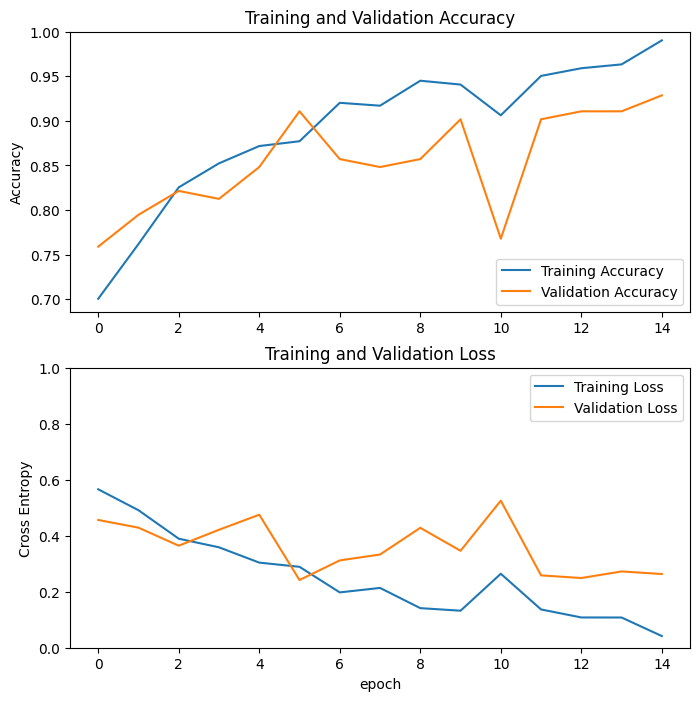

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Avaluació

In [27]:
loss, accuracy = model.evaluate(test_dataset)

7/7 [==============================] - 4s 66ms/step - loss: 0.2994 - accuracy: 0.9107


In [28]:
from tensorflow.keras.metrics import Precision, Recall, AUC
pre = Precision()
re = Recall()
auc = AUC()
y_vec = []
yhat_vec = []
for batch in test_dataset.as_numpy_iterator(): 
    X, y = batch
    y_vec.append(y)
    #print(y)
    yhat = model.predict(X)
    yhat_vec.append(yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    auc.update_state(y, yhat)

1/1 [==============================] - 0s 31ms/step


In [29]:
print(pre.result(), re.result(),auc.result())

tf.Tensor(0.8548387, shape=(), dtype=float32) tf.Tensor(0.9814815, shape=(), dtype=float32) tf.Tensor(0.96280324, shape=(), dtype=float32)


In [30]:
precision =0.8548387
recall = 0.9814815
F1 = 2/((1/precision)+(1/recall))
print(F1)

0.9137931059453029
